# Predictive maintenance for engines

Getting started.

- In order to have everything executed, the following pre requisites should be installed:
- You should also have an Azure ML Workspace and create a json file in this directory: `.azureml/config.json` that has the following content:

```json
{
    "subscription_id": "subscriptionguid",
    "resource_group": "resourcegroupname",
    "workspace_name": "workspacename"
}
```

## Imports

In [1]:
# This section enables to use the module code referenced in the repo
import os
import os.path
import sys
import numpy as np
import time
from datetime import date
import pandas as pd

from arcus.azureml.environment.aml_environment import AzureMLEnvironment

In [2]:
import arcus.ml.dataframes as adf
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Bidirectional, GRU, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import EarlyStopping
from azureml.exceptions import ComputeTargetException, WebserviceException


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Arcus connectivity

In [ ]:
azure_config_file = '.azureml/config.json'
aml = AzureMLEnvironment.Create(config_file=azure_config_file)

In [28]:
training_name = 'EngineFailurePrediction'
aml_trainer = aml.start_experiment(training_name)

web_service_name = training_name.lower() + '-v4'

## Local execution, AzureML tracking

In the following section, we are creating a subfolder that will contain all files for the training in AzureML.

### Load dataset and set features

In the next section, we are executing the following:
1. Loading the data set from the AzureML workspace
1. Adding a failure column, if the ttf (time to failure) is less than 50.  
1. After that, we remove the ttf column, as we're focusing on the prediction of the failure feature
1. Lastly, we take the first 75 engines as training data, and the remaining as test data

In [33]:
dataset = aml.load_tabular_dataset('engine-data')

# Adding 'failure' column
dataset['failure'] = dataset.apply(lambda row: 0 if row.ttf > 50 else 1, axis = 1)

# Removing output features and irrelevant features
dataset.drop('ttf', axis=1, inplace=True)
dataset.drop('cycle', axis=1, inplace=True) 

# Taking datasets and extract training/test data
seq_length = 30
train_df = dataset[dataset.engine_id <= 75]
test_df = dataset[dataset.engine_id > 75]

print(f'Training samples: {len(train_df)}')
print(f'Test samples: {len(test_df)}')

dataset.tail(5)

Training samples: 15159
Test samples: 5472


,engine_id,setting1,setting2,setting3,temp_fan_inlet,temp_lpc_outlet,temp_hpc_outlet,temp_lpt_outlet,pressure_fan_inlet,pressure_bypass_duct,...,corrected_fan_speed,corrected_core_speed,bypass_ratio,burner_fuel_air_ratio,bleed_enthalpy,demanded_fan_speed,demanded_corrected_fan_speed,hpt_collant_bleed,lpt_coolant_bleed,failure
20626,100,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,1
20627,100,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,1
20628,100,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,1
20629,100,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1
20630,100,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,21.61,...,2388.26,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,1


### Specify sliding windows for the LSTM network

A sliding window will contain a number of sequential (time series based) samples that will be used to predict the last failure feature of that window.  As LSTMs are Recurrent Neural Networks, they will keep the previous samples, leading up to the last section of the time window in memory and use it in their predictions.

#### Reusable time sliding function

In [34]:
from sklearn.preprocessing import MinMaxScaler

def get_windows(sorted_df: pd.DataFrame, window_size: int, window_stride: int = 1, group_column: str = None, zero_padding: bool = False, remove_group_column: bool = False, target_column: str = None) -> np.array:
    if group_column is None:
        return __get_windows_from_group(sorted_df, window_size, window_stride, zero_padding, target_column)

    else:
        windows = None
        targets = None
        
        # create unique list of groups
        _groups = sorted_df[group_column].unique()

        for key in _groups:
            _group_df = sorted_df[:][sorted_df[group_column] == key]
            if(remove_group_column):
                _group_df.drop(group_column, axis=1, inplace=True)
            _current_windows, _current_targets = __get_windows_from_group(
                _group_df, window_size, window_stride, zero_padding, target_column)
            if windows is None:
                windows = _current_windows
            else:
                windows = np.concatenate((windows, _current_windows))

            if target_column is not None:
                if targets is None:
                    targets = _current_targets
                else:
                    targets = np.concatenate((targets, _current_targets))

        return windows, targets

def __get_windows_from_group(sorted_df: pd.DataFrame, window_size: int, 
                             window_stride: int = 1, zero_padding: bool = False,
                             target_column:str = None) -> np.array:
    # zero based row to take the leading window from - this row will be last row in the window
    _start_row_idx = 0 if zero_padding else window_size - 1
    # will contain all windows
    windows = list()
    targets = list()
    
    # range will be from start_row to row_count
    for __current_row_idx in range(_start_row_idx, len(sorted_df)):
        __slice_begin_idx = (__current_row_idx - window_size +
                             1) if __current_row_idx >= window_size else 0
        window_df = sorted_df.copy()
        time_slice = window_df.iloc[__slice_begin_idx:__current_row_idx + 1, :]
        time_array = np.array(time_slice.values)
        if(zero_padding):
            _rows_to_pad = window_size - __current_row_idx - 1
            if(_rows_to_pad > 0):
                padding_matrix = np.zeros(
                    (_rows_to_pad, len(sorted_df.columns)))
                time_array = np.concatenate((padding_matrix, time_array))
        if(target_column is not None):
            _target_colidx = sorted_df.columns.get_loc(target_column)
            time_array, target_array = __pop_from_array(time_array, _target_colidx)
            targets.append(target_array)

        scaler = preprocessing.MinMaxScaler().fit(time_array) 

        time_array = scaler.transform(time_array)
        windows.append(time_array)
    return np.array(windows), np.array(targets) if target_column is not None else None

def __pop_from_array(my_array,pc):
    i = pc
    pop = my_array[:,i]
    new_array = np.hstack((my_array[:,:i],my_array[:,i+1:]))
    return new_array, pop


#### Time windowing 

In [35]:
X_train, y_train = get_windows(train_df, seq_length, group_column='engine_id', zero_padding=True, target_column='failure', remove_group_column=True)
X_test, y_test = get_windows(test_df, seq_length, group_column='engine_id', zero_padding=True, target_column='failure', remove_group_column=True)

# Only keeping the last values of the target arrays
y_train = y_train[:, -1]
y_test = y_test[:, -1]

#shuffled_p = np.random.permutation(len(X_train))
#X_train = X_train[shuffled_p]
#y_train = y_train[shuffled_p]

### Training of LSTM network

In [9]:
def build_lstm(dropout = 0.0, lstm_nodes: int = 20, bi_directional: bool = False):
    model = Sequential()
    data_shape = (X_train.shape[1], X_train.shape[2])
    model.add(LSTM(lstm_nodes, input_shape=data_shape, activation = 'relu', return_sequences = True))
    model.add(Dropout(dropout))
    
    if(bi_directional):
        model.add(Bidirectional(LSTM(30, activation='relu')))
        model.add(Dropout(dropout))
    else:
        model.add(GRU(30))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = ('binary_crossentropy'), optimizer='adam', metrics=['acc'])
    return model

In [10]:
model = build_lstm(dropout = 0.2, lstm_nodes=50, bi_directional=False)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            15000     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
gru (GRU)                    (None, 30)                7380      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 22,411
Trainable params: 22,411
Non-trainable params: 0
_________________________________________________________________


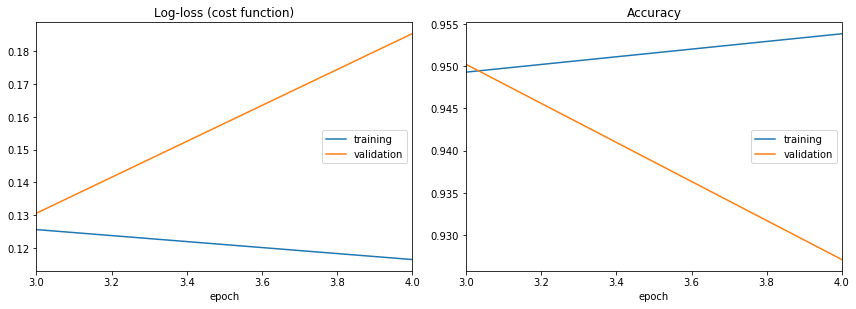

Log-loss (cost function):
training   (min:    0.116, max:    0.226, cur:    0.116)
validation (min:    0.131, max:    0.185, cur:    0.185)

Accuracy:
training   (min:    0.904, max:    0.954, cur:    0.954)
validation (min:    0.927, max:    0.950, cur:    0.927)
12127/12127 [==============================] - 8s 699us/sample - loss: 0.1165 - acc: 0.9538 - val_loss: 0.1854 - val_acc: 0.9271


In [11]:
epoch_count = 4
batch_size = 32
lstm_nodes = 50
dropout = 0.2

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
tensorboard_callback = tf.keras.callbacks.TensorBoard('./tensor_logs', histogram_freq=1),
model_checkpoint_callback = ModelCheckpoint(
    filepath='outputs/model_checkpoint',
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
cbs =[early_stopping, *tensorboard_callback, model_checkpoint_callback, PlotLossesCallback()]

_run = aml_trainer.new_run(copy_folder = True, metrics = {'epochs': epoch_count, 'batch_size': batch_size, 'lstm_nodes': lstm_nodes, 'dropout': dropout})

model = build_lstm(dropout = dropout, lstm_nodes=lstm_nodes, bi_directional=False)

# shuffle data prior to training
model.fit(X_train, y_train,
                epochs=epoch_count,
                batch_size=batch_size,
                validation_split = 0.2,
                callbacks = cbs)

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      4197
         1.0       0.76      0.95      0.84      1275

    accuracy                           0.92      5472
   macro avg       0.87      0.93      0.89      5472
weighted avg       0.93      0.92      0.92      5472

[[3808  389]
 [  60 1215]]
accuracy 91.79459064327486
roc_auc 0.8709847021536128


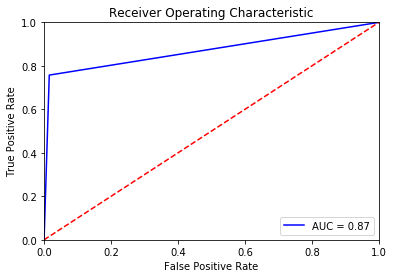

INFO:tensorflow:Assets written to: outputs/model/assets


INFO - Assets written to: outputs/model/assets


In [12]:
aml_trainer.evaluate_classifier(model, X_test, y_test, show_roc = True, upload_model = True)   


## AmlCompute training

In [58]:
args = {
    '--epochs': 2,
    '--batch_size': 32, 
    '--es_patience': 15,
    '--dropout': 20,
    '--lstmnodes': 80
}
compute_run = aml_trainer.start_training(training_name, environment_type='tensorflow', 
                       script_parameters=args,
                       compute_target='gpu-training', gpu_compute=True)


Getting environment for type tensorflow
Taking AzureML-TensorFlow-2.0-GPU as base environment
https://ml.azure.com/experiments/EngineFailurePrediction/runs/EngineFailurePrediction_1596115224_e7d4138c?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Deploy model to AzureML

### Register model to AzureML registry

In [6]:
from azureml.core import Run

def deploy_model(experiment, run_number, model_location):
    for run in experiment.get_runs():
        if run.number == run_number:
            model = run.register_model(model_name=experiment.name,
                           tags={'output': 'series', 'input': 'charts'},
                           model_path=model_location)
            print(model.name, model.id, model.version, sep='\t')
            break
    
deploy_model(aml_trainer._AzureMLTrainer__experiment, 21, 'outputs/model_checkpoint')

Run Number's semantics may be modified in the future
Run Number's semantics may be modified in the future


EngineFailurePrediction	EngineFailurePrediction:3	3


In [7]:
from azureml.core.model import Model
series_model = Model.list(aml.get_azureml_workspace(), name=training_name, latest=True)[0]
print(series_model)

Model(workspace=Workspace.create(name='savanh-time-travel', subscription_id='b73995e3-caad-4882-8644-f2175789c3ff', resource_group='savanh-time-travel'), name=EngineFailurePrediction, id=EngineFailurePrediction:3, version=3, tags={'output': 'series', 'input': 'charts'}, properties={})


### Execute this section to deploy to an AKS inference cluster

__Creation of the inference cluster__

In [9]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = 'inferencecluster'

# Check to see if the cluster already exists
try:
    deployment_target = ComputeTarget(workspace=aml.get_azureml_workspace(), name=aks_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="Standard_NC6")

    # Create the cluster
    deployment_target = ComputeTarget.create(
        workspace=aml.get_azureml_workspace(), name=aks_name, provisioning_configuration=prov_config
    )

    deployment_target.wait_for_completion(show_output=True)

Creating a new compute target...
Creating...................................................................................
SucceededProvisioning operation finished, operation "Succeeded"


__Creation of the AKS deployment config__

In [10]:
from azureml.core.webservice import AksWebservice

deployment_config = AksWebservice.deploy_configuration(autoscale_enabled=False, auth_enabled=True,
                                                    num_replicas=1,
                                                    cpu_cores=1,gpu_cores=1,
                                                    memory_gb=1)

In [ ]:
from azureml.core import Environment
from azureml.core.webservice import Webservice

try:
    service = Webservice(name=web_service_name, workspace=aml.get_azureml_workspace())
    print('Web service exists and retrieved')
except WebserviceException:
    print('Deploying model as web service')
    service = Model.deploy(workspace=aml.get_azureml_workspace(), 
                           name=web_service_name, 
                           models=[series_model], 
                           deployment_target=deployment_target,
                           inference_config=inference_config, 
                           deployment_config=deployment_config)
    service.wait_for_deployment(show_output=True)
    print(service.state)
    service.get_logs()    
    print('Web service created')
    


### Execute this section to deploy to an ACI inference instance

__Creation of the AKS deployment config__

In [31]:
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import Model

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1, 
                                                       auth_enabled=True, enable_app_insights=True)
deployment_target = None

### Deployment of inference web service endpoint

In [32]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig
myenv = Environment.get(aml.get_azureml_workspace(), training_name)
inference_config = InferenceConfig(entry_script=training_name + '/score.py', environment=myenv)


In [33]:
from azureml.core import Environment
from azureml.core.webservice import Webservice

try:
    service = Webservice(name=web_service_name, workspace=aml.get_azureml_workspace())
    print('Web service exists and retrieved')
except WebserviceException:
    print('Deploying model as web service')
    service = Model.deploy(workspace=aml.get_azureml_workspace(), 
                           name=web_service_name, 
                           models=[series_model], 
                           deployment_target=deployment_target,
                           inference_config=inference_config, 
                           deployment_config=deployment_config)
    service.wait_for_deployment(show_output=True)
    print(service.state)
    service.get_logs()    
    print('Web service created')

Deploying model as web service
Running........................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
Web service created


## Update service endpoint with latest scoring script

In [13]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig
myenv = Environment.get(aml.get_azureml_workspace(), training_name)
inference_config = InferenceConfig(entry_script=training_name + '/score.py', environment=myenv)

Warning, custom base image or base dockerfile detected without a specified `inferencing_stack_version`. Please set environment.inferencing_stack_version='latest'


In [14]:
from azureml.core import Environment
from azureml.core.webservice import Webservice

service = Webservice(name=web_service_name, workspace=aml.get_azureml_workspace())


In [15]:
from azureml.core.model import Model
series_model = Model.list(aml.get_azureml_workspace(), name=training_name, latest=True)[0]
print(series_model)

Model(workspace=Workspace.create(name='savanh-time-travel', subscription_id='b73995e3-caad-4882-8644-f2175789c3ff', resource_group='savanh-time-travel'), name=EngineFailurePrediction, id=EngineFailurePrediction:2, version=2, tags={'output': 'series', 'input': 'charts'}, properties={})


In [16]:
service.update(models=[series_model], inference_config=inference_config, enable_app_insights=True)

## Consume Model endpoint

In [34]:
from azureml.core import Environment
from azureml.core.webservice import Webservice

service = Webservice(name=web_service_name, workspace=aml.get_azureml_workspace())

In [35]:
input_data = np.array([np.random.rand(30,24)])
#input_data = np.random.rand(30,24)
print(input_data.shape)

(1, 30, 24)


In [ ]:
service.get_keys()

In [37]:
import requests
import json

headers = {'Content-Type': 'application/json'}

headers['Authorization'] = 'Bearer '+service.get_keys()[0]

test_sample = json.dumps({'data': input_data.tolist()})
#test_sample = json.dumps({'data': np.random.rand(30,24).tolist()})

response = requests.post(
    service.scoring_uri, data=test_sample, headers=headers)
print(f'Status: {response.status_code}')
print(f'Call duration: {response.elapsed}')

if(response.ok):
    results = response.json()
    print(results)
else:
    print(service.get_logs().splitlines())    

Status: 200
Call duration: 0:00:00.384704
[[0.00016439426690340042]]
